In [26]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [27]:
path = r"C:\data\benchmarks"
path = r"/home/perdelt/benchmarks"

In [28]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties


def get_performance_single(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = evaluation.get_df_benchmarking()
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Goodput (requests/second)': 'sum',
        'num_errors': 'sum',
        'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [29]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title} by Number of Tenants and Type")
    plt.tight_layout()
    filename = "tpcc_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [30]:
codes = [
    # container
    '1750849896', #tenants=1
    '1750783835', #tenants=2
    '1750800801', #tenants=5
    '1750806919', #tenants 6
    '1750813297', #tenants=7
    '1750819742', #tenants=8
    '1750826579', #tenants=9
    '1750840810', #tenants=10
    
    # database
    '1750848184', #tenants=1
    '1750782080', #tenants=2
    '1750798872', #tenants=5
    '1750804904', #tenants=6
    '1750811177', #tenants=7
    '1750817654', #tenants=8
    '1750824366', #tenants=9
    '1750831264', #tenants=10
    
    #schema
    '1750846468', #tenants=1
    '1750780338', #tenants=2
    '1750796864', #tenants=5
    '1750802821', #tenants=6   
    '1750809059', #tenants=7
    '1750815548', #tenants=8
    '1750822119', #tenants=9
    '1750829043', #tenants=10
]

In [55]:
df_performance = get_performance_all_single(codes)
df_performance.T

connection_pod,PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-0-1-1,PostgreSQL-1-1-65536-1-2-1,PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-4-1-1,PostgreSQL-1-1-65536-1-1-1,PostgreSQL-1-1-65536-2-1-1,PostgreSQL-1-1-65536-3-1-1,...,PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-2-2,PostgreSQL-1-1-65536-2-3,PostgreSQL-1-1-65536-2-4,PostgreSQL-1-1-65536-2-5,PostgreSQL-1-1-65536-2-6,PostgreSQL-1-1-65536-2-7,PostgreSQL-1-1-65536-2-8,PostgreSQL-1-1-65536-2-9,PostgreSQL-1-1-65536-2-10
connection,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-0-1,PostgreSQL-1-1-65536-1-2,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-4-1,PostgreSQL-1-1-65536-1-1,PostgreSQL-1-1-65536-2-1,PostgreSQL-1-1-65536-3-1,...,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-2
configuration,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536-0,PostgreSQL-1-1-65536-4,PostgreSQL-1-1-65536-1,PostgreSQL-1-1-65536-2,PostgreSQL-1-1-65536-3,...,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536,PostgreSQL-1-1-65536
experiment_run,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
client,1,2,1,1,2,2,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
pod,5t5rh.dbmsbenchmarker,v8x7q.dbmsbenchmarker,rjvct.dbmsbenchmarker,h8xnb.dbmsbenchmarker,c5mbg.dbmsbenchmarker,5dnq6.dbmsbenchmarker,hln9q.dbmsbenchmarker,zvtsc.dbmsbenchmarker,hpljk.dbmsbenchmarker,mtx7z.dbmsbenchmarker,...,w2dv4.dbmsbenchmarker,qrl7z.dbmsbenchmarker,vqwxw.dbmsbenchmarker,snfbg.dbmsbenchmarker,zzkmq.dbmsbenchmarker,qs7rp.dbmsbenchmarker,69qbb.dbmsbenchmarker,qm42m.dbmsbenchmarker,jt7rp.dbmsbenchmarker,k2z8s.dbmsbenchmarker
pod_count,1,1,1,1,1,1,1,1,1,1,...,10,10,10,10,10,10,10,10,10,10
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,...,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,...,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536,...,65536,65536,65536,65536,65536,65536,65536,65536,65536,65536
time,600,600,600,600,600,600,600,600,600,600,...,600,600,600,600,600,600,600,600,600,600


In [59]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

connection           configuration  \
num_tenants type                                                          
1           container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
2           container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
5           container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
6           container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-5-2  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
7           container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-6-1  PostgreSQL-1-1-65536-6   
            container  PostgreSQL-1-1-65536-5-2  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-6-2  PostgreSQL-1-1-65536-6   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-3-2  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
8           container  PostgreSQL-1-1-65536-6-1  PostgreSQL-1-1-65536-6   
            container  PostgreSQL-1-1-65536-0-1  PostgreSQL-1-1-65536-0   
            container  PostgreSQL-1-1-65536-5-1  PostgreSQL-1-1-65536-5   
            container  PostgreSQL-1-1-65536-4-1  PostgreSQL-1-1-65536-4   
            container  PostgreSQL-1-1-65536-2-1  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-3-1  PostgreSQL-1-1-65536-3   
            container  PostgreSQL-1-1-65536-1-1  PostgreSQL-1-1-65536-1   
            container  PostgreSQL-1-1-65536-7-1  PostgreSQL-1-1-65536-7   
            container  PostgreSQL-1-1-65536-2-2  PostgreSQL-1-1-65536-2   
            container  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-

0.5
1.5
2.5
3.5
4.5
5.5
6.5


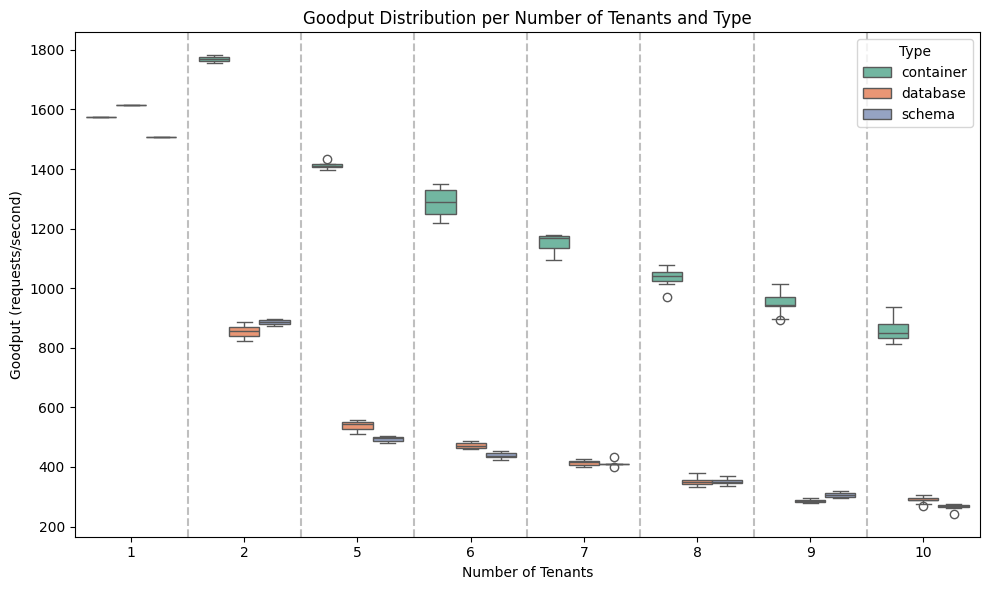

In [68]:
df = df_performance[df_performance['client']=='1']
plt.figure(figsize=(10, 6))

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Goodput (requests/second)',
    hue='type',
    palette='Set2'  # consistent colors per type
)
# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    print(xpos)
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)

plt.title("Goodput Distribution per Number of Tenants and Type")
plt.xlabel("Number of Tenants")
plt.ylabel("Goodput (requests/second)")
plt.legend(title="Type")
plt.tight_layout()
plt.show()

<Axes: >

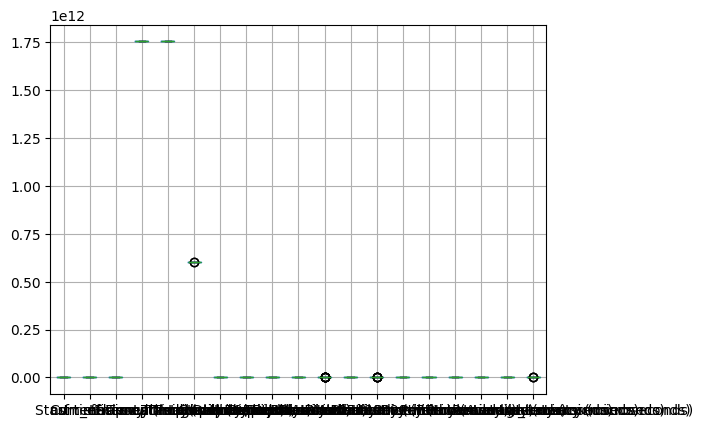

In [57]:
df_plot = df_performance[df_performance['client']=='1']
df_plot.boxplot()

In [58]:
df_plot = df_performance[df_performance['client']=='1']
df_grouped = df_plot.groupby(['num_tenants', 'type']).agg({'Goodput (requests/second)':'count'})
print(df_grouped)
#for (num_tenants, typ), group_df in grouped:
#    print(f"\nGroup: num_tenants={num_tenants}, type={typ}")
#    print(group_df)


                       Goodput (requests/second)
num_tenants type                                
1           container                          1
            database                           1
            schema                             1
2           container                          2
            database                           2
            schema                             2
5           container                          5
            database                           5
            schema                             5
6           container                          6
            database                           6
            schema                             6
7           container                          7
            database                           7
            schema                             7
8           container                          8
            database                           8
            schema                             8
9           containe

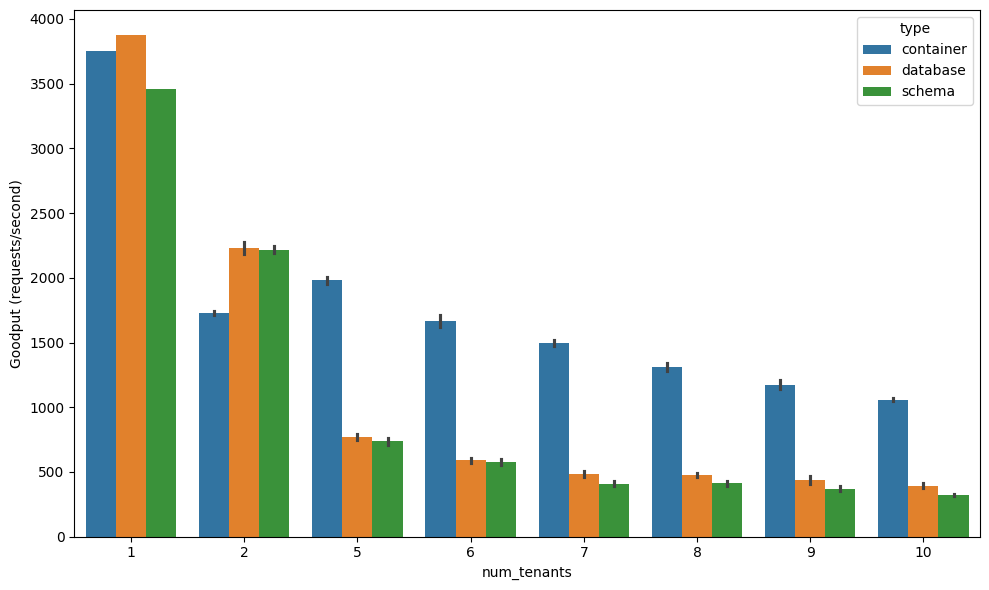

,connection,configuration,experiment_run,client,pod,pod_count,bench,profile,target,time,...,Latency Distribution.Maximum Latency (microseconds),Latency Distribution.Median Latency (microseconds),Latency Distribution.Minimum Latency (microseconds),Latency Distribution.25th Percentile Latency (microseconds),Latency Distribution.90th Percentile Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),Latency Distribution.75th Percentile Latency (microseconds),Latency Distribution.Average Latency (microseconds),type,num_tenants
connection_pod,,,,,,,,,,,,,,,,,,,,,
PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-0,1,2,v8x7q.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1629694,19983,831,13852,50701,109435,31777,26257,container,1
PostgreSQL-1-1-65536-1-2-1,PostgreSQL-1-1-65536-1-2,PostgreSQL-1-1-65536-1,1,2,c5mbg.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,33040568,20628,753,13209,56339,122022,33784,55609,container,2
PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-0,1,2,5dnq6.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,33033865,20856,736,13269,58664,128475,35020,55733,container,2
PostgreSQL-1-1-65536-4-2-1,PostgreSQL-1-1-65536-4-2,PostgreSQL-1-1-65536-4,1,2,krm6w.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1785998,37302,917,23129,103635,228267,61328,50471,container,5
PostgreSQL-1-1-65536-0-2-1,PostgreSQL-1-1-65536-0-2,PostgreSQL-1-1-65536-0,1,2,9pjj6.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1113342,37140,866,23073,102256,219485,61071,49802,container,5
PostgreSQL-1-1-65536-2-2-1,PostgreSQL-1-1-65536-2-2,PostgreSQL-1-1-65536-2,1,2,69vwb.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,2048679,36409,971,22779,100180,220110,59532,49051,container,5
PostgreSQL-1-1-65536-3-2-1,PostgreSQL-1-1-65536-3-2,PostgreSQL-1-1-65536-3,1,2,hbm84.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1202232,36412,908,22756,99111,214302,59393,48601,container,5
PostgreSQL-1-1-65536-1-2-1,PostgreSQL-1-1-65536-1-2,PostgreSQL-1-1-65536-1,1,2,4hw6w.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,1148407,37216,947,23211,103497,230145,61130,50516,container,5
PostgreSQL-1-1-65536-5-2-1,PostgreSQL-1-1-65536-5-2,PostgreSQL-1-1-65536-5,1,2,2s7kc.dbmsbenchmarker,1,tpcc,postgres,65536,600,...,23392802,45137,873,27495,119539,266039,72510,61694,container,6


In [34]:
# Sample boxplot
df_plot = df_performance[df_performance['client']=='2']
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_plot, x="num_tenants", y="Goodput (requests/second)", hue="type")
plt.tight_layout()
plt.show()
df_plot

                                          connection           configuration  \
connection_pod                                                                 
PostgreSQL-1-1-65536-0-2-1  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
PostgreSQL-1-1-65536-1-2-1  PostgreSQL-1-1-65536-1-2  PostgreSQL-1-1-65536-1   
PostgreSQL-1-1-65536-0-2-1  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   
PostgreSQL-1-1-65536-4-2-1  PostgreSQL-1-1-65536-4-2  PostgreSQL-1-1-65536-4   
PostgreSQL-1-1-65536-0-2-1  PostgreSQL-1-1-65536-0-2  PostgreSQL-1-1-65536-0   

                           experiment_run client                    pod  \
connection_pod                                                            
PostgreSQL-1-1-65536-0-2-1              1      2  v8x7q.dbmsbenchmarker   
PostgreSQL-1-1-65536-1-2-1              1      2  c5mbg.dbmsbenchmarker   
PostgreSQL-1-1-65536-0-2-1              1      2  5dnq6.dbmsbenchmarker   
PostgreSQL-1-1-65536-4-2-1              1      2  krm6w.dbmsbenc

ValueError: No objects to concatenate

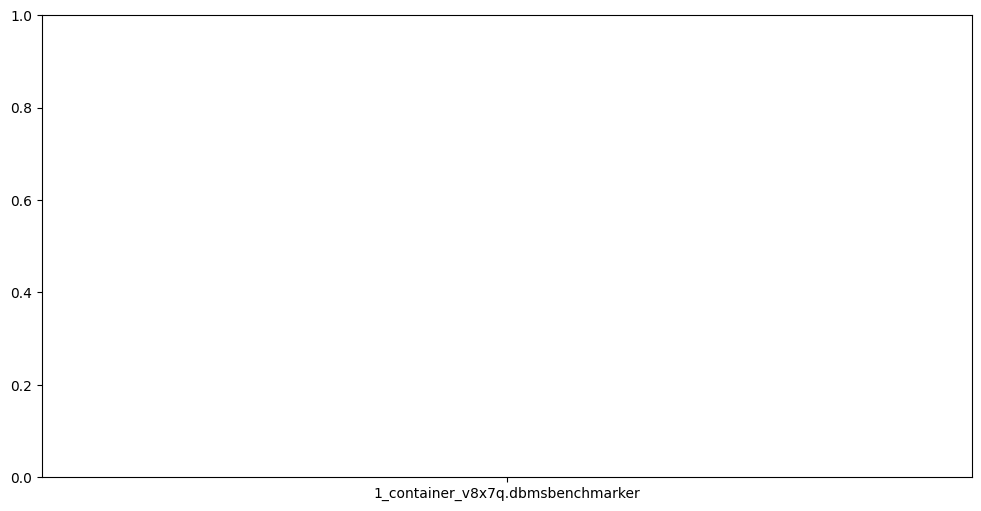

In [35]:
df = df_plot.copy()
# Create a unique ID per row (could also use df.index)
df["x"] = df["num_tenants"].astype(str) + "_" + df["type"] + "_" + df["pod"].astype(str)
print(df.head())
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="x",
    y="Goodput (requests/second)",
    hue="type",
    dodge=False,
    estimator=None
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ValueError: No objects to concatenate

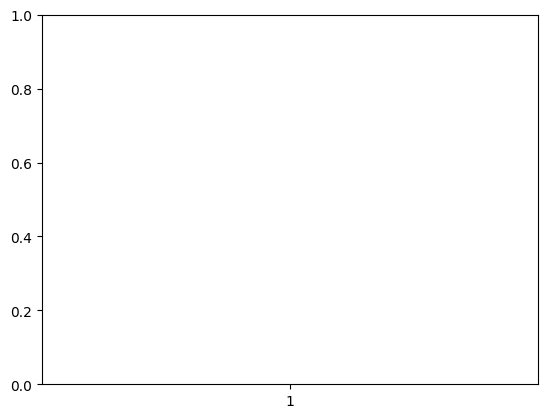

In [36]:
# Use dodge=True to place hue bars side-by-side (not stacked)
ax = sns.barplot(
    data=df,
    x="num_tenants",
    y="Goodput (requests/second)",
    hue="type",
    dodge=True,
    estimator=None  # <--- disables aggregation: one bar per row
)

plt.title("Goodput per Tenant and Type")
plt.tight_layout()
plt.show()

In [37]:
df_performance = get_performance_all(codes)
df_performance

,client,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),type,num_tenants
0,1,1573.971516,6,62914.000000,container,1
1,2,3752.529821,43,26257.000000,container,1
0,1,3538.888175,38,55887.500000,container,2
1,2,3451.894695,1500,55671.000000,container,2
0,1,7067.734660,86,69814.400000,container,5
1,2,9906.644639,164,49688.200000,container,5
0,1,7723.216164,111,76710.500000,container,6
1,2,10009.044550,195,59045.000000,container,6
0,1,8062.484634,111,85663.428571,container,7
1,2,10477.129684,213,65752.285714,container,7


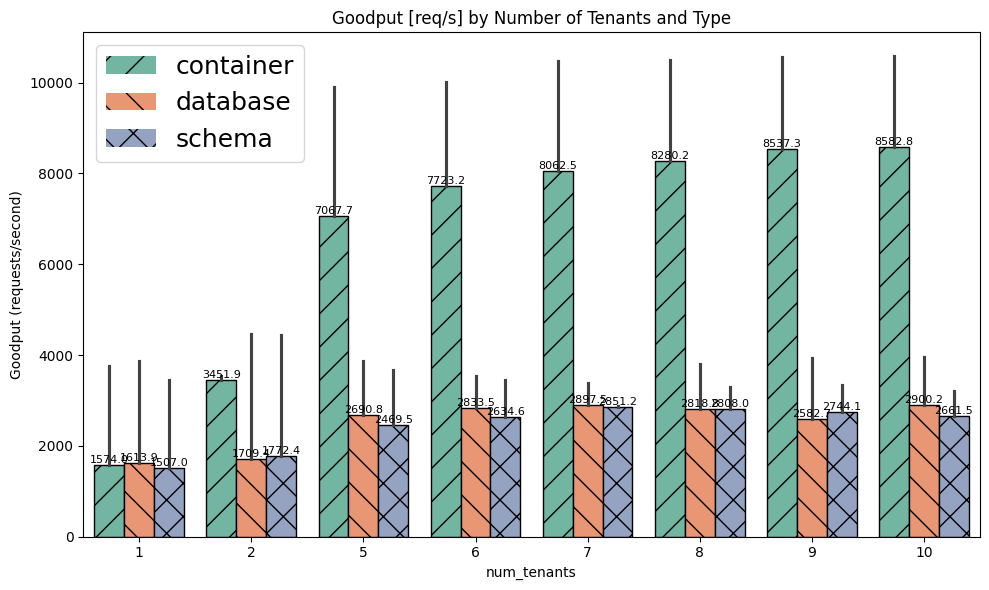

In [38]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

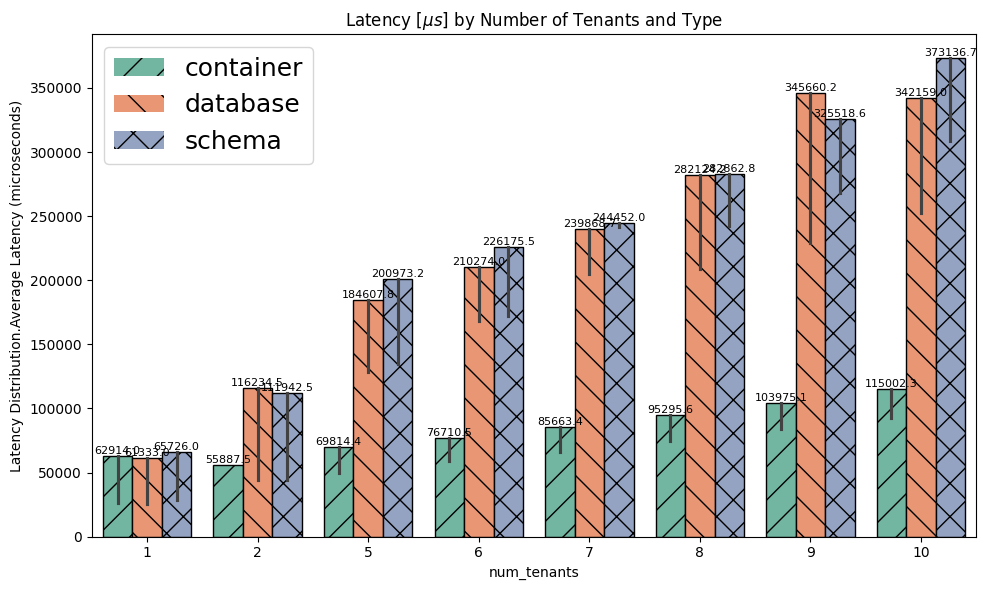

In [39]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

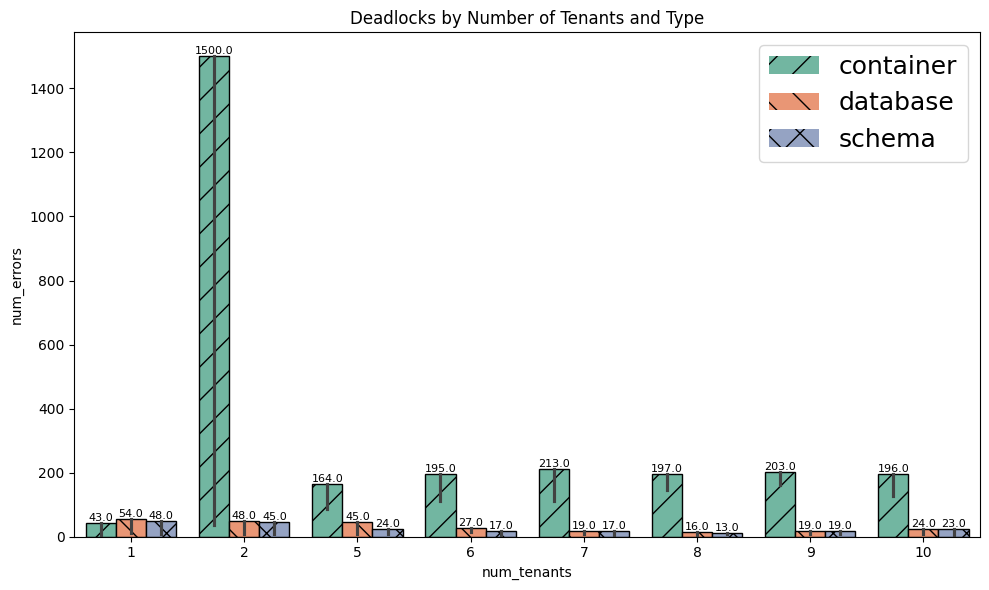

In [40]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [41]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-1-1-65536-0-1,261.0,104.0,157.0,1,1,0,1,2720,container,1
PostgreSQL-1-1-65536-0-2,261.0,104.0,157.0,1,1,0,2,6264,container,1
PostgreSQL-1-1-65536-0-1,306.0,116.0,189.0,1,1,0,1,2720,container,2
PostgreSQL-1-1-65536-0-2,306.0,116.0,189.0,1,1,0,2,6647,container,2
PostgreSQL-1-1-65536-1-1,317.0,125.0,191.0,1,1,1,1,2720,container,2
PostgreSQL-1-1-65536-1-2,317.0,125.0,191.0,1,1,1,2,6712,container,2
PostgreSQL-1-1-65536-0-1,278.0,112.0,166.0,1,1,0,1,2720,container,5
PostgreSQL-1-1-65536-0-2,278.0,112.0,166.0,1,1,0,2,5819,container,5
PostgreSQL-1-1-65536-1-1,274.0,110.0,164.0,1,1,1,1,2720,container,5
PostgreSQL-1-1-65536-1-2,274.0,110.0,164.0,1,1,1,2,5818,container,5


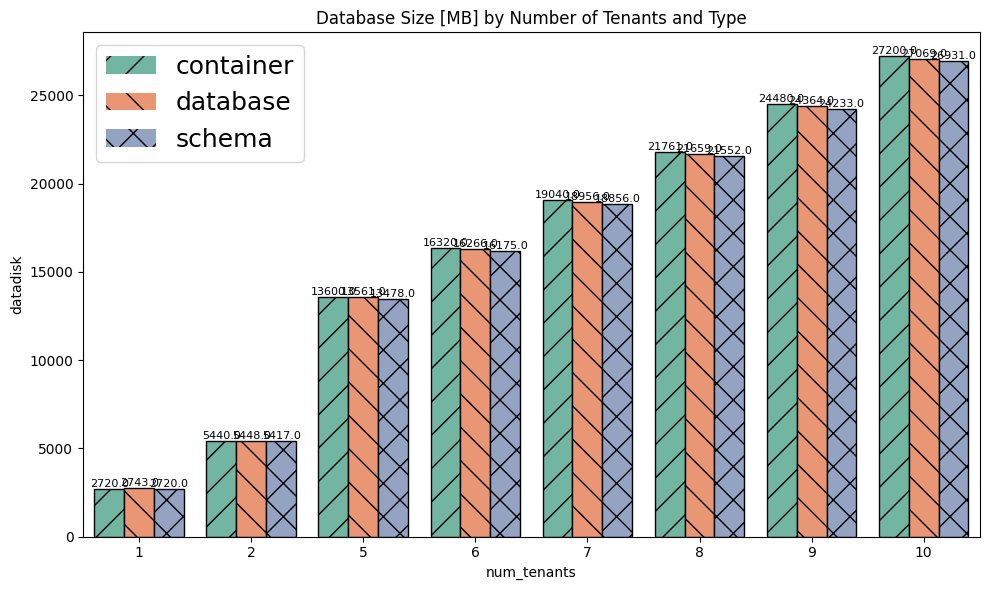

In [42]:
df_performance_first = df_performance[df_performance['client'] == '1']
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

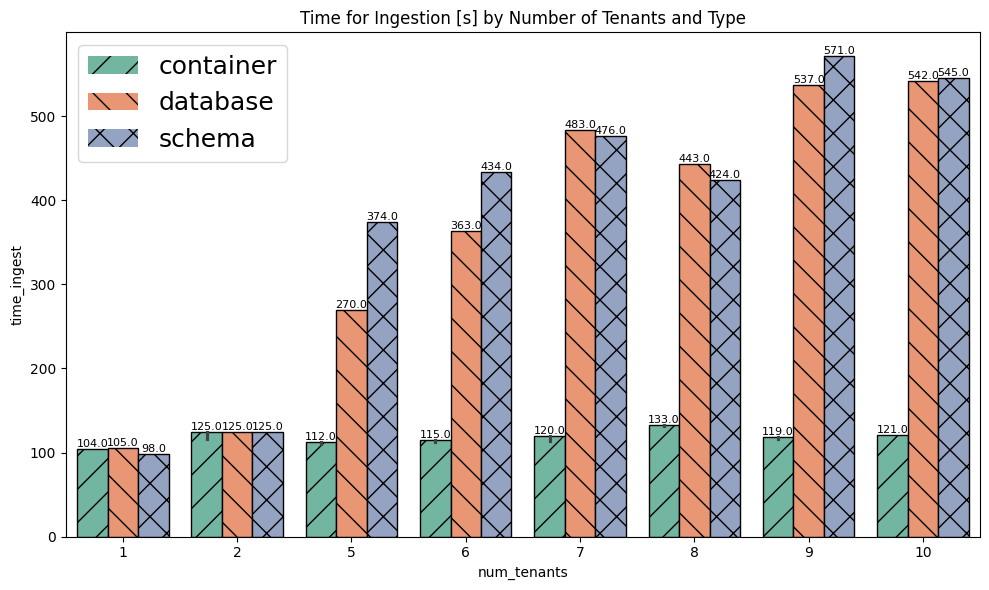

In [43]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

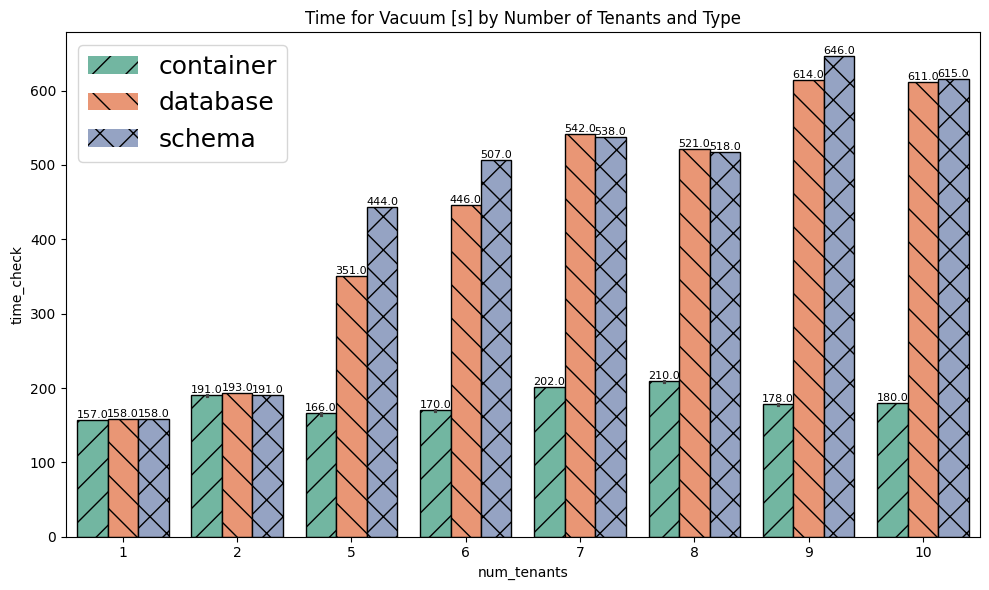

In [44]:
plot_bars(df_performance, y='time_check', title='Time for Vacuum [s]', estimator='max')

In [45]:
df_performance = get_monitoring_stream_all(codes)
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,7969.80,5.19,7.08,18.47,container,1
1,2,12247.36,7.35,11.06,22.35,container,1
0,1,19394.54,10.63,14.63,38.60,container,2
1,2,30704.09,12.49,18.05,38.14,container,2
0,1,33848.08,25.17,34.00,57.49,container,5
1,2,31887.17,30.76,44.31,54.23,container,5
0,1,34559.77,29.63,39.73,59.26,container,6
1,2,32188.56,35.59,50.77,57.63,container,6
0,1,35471.47,34.00,45.34,59.88,container,7
1,2,34264.95,40.32,57.02,57.95,container,7


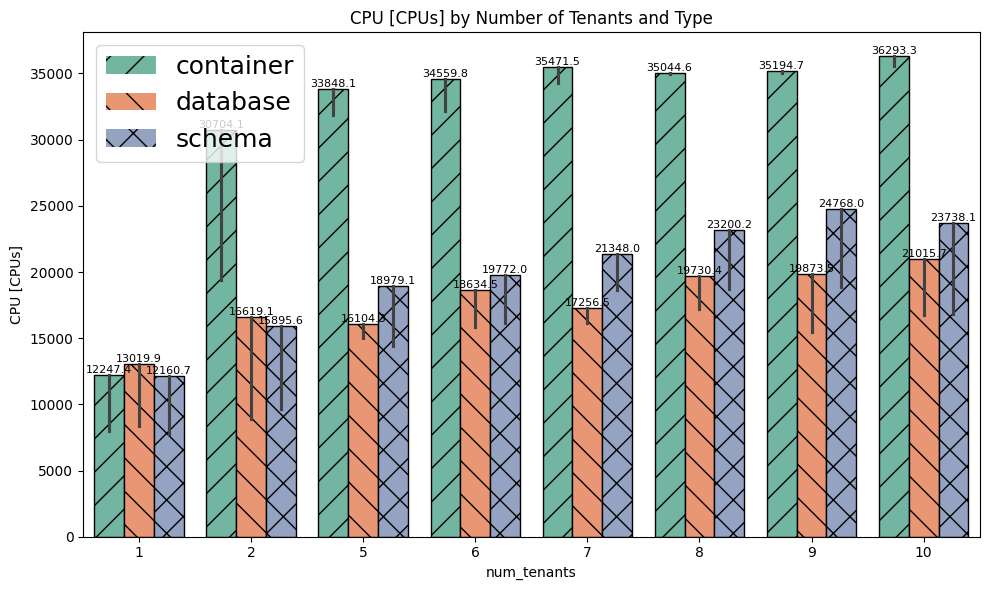

In [46]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

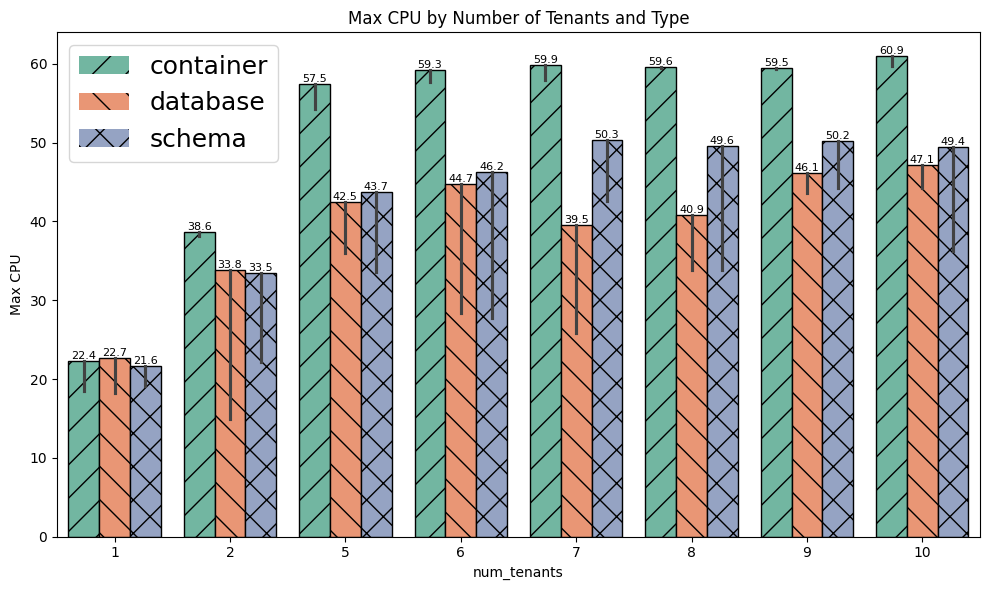

In [47]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='max')

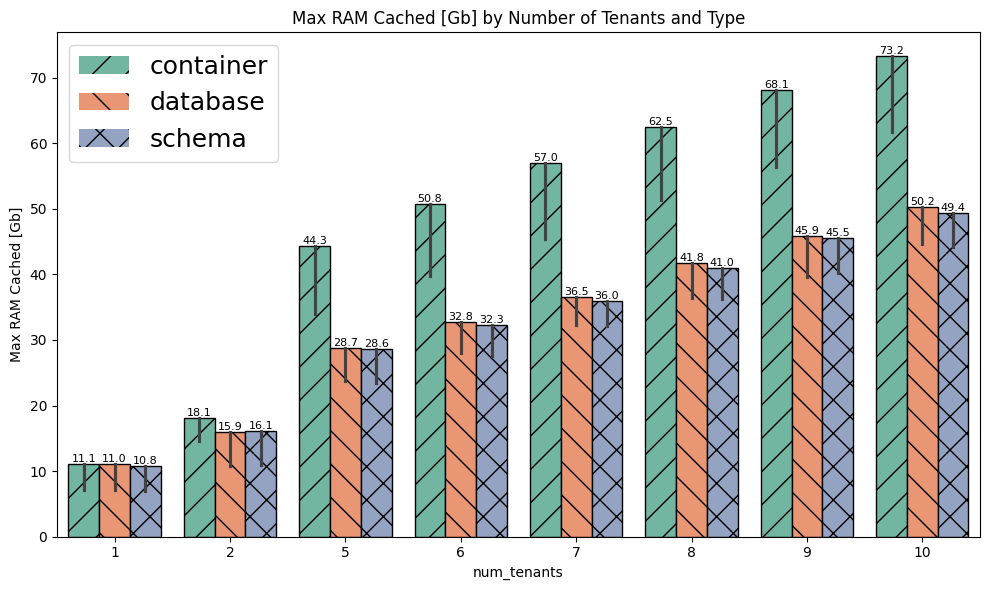

In [48]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='max')

# Single Experiment

In [49]:
code = '1750741356'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [50]:
df=get_performance_single(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df.T

connection_pod,PostgreSQL-1-1-16384-1-1,PostgreSQL-1-1-16384-1-2,PostgreSQL-1-1-16384-1-3,PostgreSQL-1-1-16384-1-4,PostgreSQL-1-1-16384-1-5,PostgreSQL-1-1-16384-1-6,PostgreSQL-1-1-16384-1-7,PostgreSQL-1-1-16384-1-8,PostgreSQL-1-1-16384-1-9,PostgreSQL-1-1-16384-2-1,PostgreSQL-1-1-16384-2-2,PostgreSQL-1-1-16384-2-3,PostgreSQL-1-1-16384-2-4,PostgreSQL-1-1-16384-2-5,PostgreSQL-1-1-16384-2-6,PostgreSQL-1-1-16384-2-7,PostgreSQL-1-1-16384-2-8,PostgreSQL-1-1-16384-2-9
connection,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-1,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2,PostgreSQL-1-1-16384-2
configuration,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384,PostgreSQL-1-1-16384
experiment_run,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
client,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2
pod,v8pgd.dbmsbenchmarker,bzrfv.dbmsbenchmarker,tqj89.dbmsbenchmarker,sk5cz.dbmsbenchmarker,5whq6.dbmsbenchmarker,h4z87.dbmsbenchmarker,9l5dp.dbmsbenchmarker,tdpzd.dbmsbenchmarker,jrbdr.dbmsbenchmarker,pwlbg.dbmsbenchmarker,f9gzm.dbmsbenchmarker,zkgfb.dbmsbenchmarker,nz6tc.dbmsbenchmarker,8c249.dbmsbenchmarker,n6x9k.dbmsbenchmarker,s6j9t.dbmsbenchmarker,gq2mn.dbmsbenchmarker,xbjz6.dbmsbenchmarker
pod_count,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
bench,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc,tpcc
profile,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres,postgres
target,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384,16384
time,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600,600


In [ ]:
get_loading_time_max(evaluation)

In [ ]:
get_monitoring_stream_single(evaluation).sort_values('client')

In [ ]:
get_monitoring_stream(evaluation)